## Robust Production - Inventory

Consider the problem of minimizing the costs associated with inventory management while ensuring that customer demand is met consistently over a planning horizon. This approach addresses the inherant uncertainty in product demands, making it a robust optimization problem.

Taking the example introduced in Ben-Tal et al. (2004) [1], let us consider a single product inventory system which is comprised of a single warehouse and $I$ identical factories. The planning horizon is $T$ periods. At time period $t$, let:
- $d_t$ denote the demand of the product at each that is uncertain.
- $v_t$ denote the amount of product in the warehouse at the beginning of the time period.
- $p_t\in {\bf R}^I$ denote the amount of product to be produced during period $t$ by each factory.
- $c_t \in {\bf R}^I$ denote the cost of producing a unit of product at each factory at time period $t$.
- $p^{\rm max}$ denote the maximal production capacity for each factory at time period $t$.
- $q^{\rm max}$ denote the maximal cumulative production capacity for each factory.
- $v^{\rm min}$ and $v^{\rm max}$ denote the minimal and maximal storage capacity of the warehouse, respectively.

With this information, we can write the inventory problem as a robust linear program

$$
\begin{array}{ll}
\text{minimize} & \sum_{t=1}^{T} c_t^Tp_t \\
\text{subject to} & 0 \leq p_t \leq p^{\rm max}{\bf 1} \quad t=1,\dots,T \\
                  & \sum_{k = 1}^{t} p_k \leq q^{\rm max}{\bf 1} \quad t=1,\dots,T \\
                  & v^{\rm min} \leq v_1 + {\bf 1}^T(\sum_{k = 1}^{t} p_k) - \sum_{k = 1}^{t} d_k \leq v^{\rm max} \quad \forall (d_1,\dots, d_T) \in \mathcal{U},\quad t=1,\dots, T\\
\end{array}
$$


In [9]:
import numpy as np 
import cvxpy as cp 
import lropt
import matplotlib.pyplot as plt

Next, we consider $I$ = 3 factories producing a product in one warehouse. The time horizon $T$ is 24 time periods. The  maximal production capacity of each one of the factories at each two-weeks period is $P(t) = 567$, and the integral production capacity of each one of the factories for a year is $Q = 13600$. The inventory at the warehouse should not be less then $300$ units, and cannot exceed $10000$ units. Initially, the inventory sits at $500$ units.

In [15]:
np.random.seed(1)
T = 8 #number of periods
I = 3 #number of factories
v_min = 300
v_max = 10000
q_max = 13600
p_max = 567
v_init = 500
alphas = np.array([1, 1.5, 2])

The production cost for at period $t$ for each factory $i$ is given by:
$$
\begin{align*}
(c_t)_i =  \alpha_i \left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad t =1,\dots,T,\quad  i=1,\dots,I,
\end{align*}
$$
where $\alpha = (1, 1.5, 2)$. The demand is uncertain and seasonal, reaching its peak in winter, with the following pattern,
$$
\begin{align*}
d^*_t =  1000\left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad  t=1, 2,\dots ,T \\
\end{align*}
$$

To handle this uncertainty, we adopt the Polyhedral uncertainty set. This uncertainty set is defined by:
$$
 \mathcal{U}_{\text{poly}} = \{(d_1,\dots,d_T) \mid (1 - \rho)  d_t^* \le d_t \le (1 + \rho) d_t^* ,\quad t=1,\dots,T\}
$$
The following code defines these parameters for the problem.

In [17]:
def setup_parameters(proportion):
    # Check if you can use t_values here as well instead of the list comprehension
    t_values = np.arange(1, T + 1)
    
    c = [(alphas * (1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5)))).flatten() for t in range(1, T + 1)]
    c = np.array(c).T
    
    d_star = 1000 * (1 + 0.5 * np.sin(np.pi * (t_values - 1) / (T * 0.5)))
    
    lhs = np.concatenate((np.eye(T), -np.eye(T)), axis=0)    
    rhs_upper = (1 + proportion) * d_star
    rhs_lower = (-1 + proportion) * d_star
    rhs = np.hstack((rhs_upper, rhs_lower))
    
    d = lropt.UncertainParameter(T, uncertainty_set=lropt.Polyhedral(lhs=lhs, rhs=rhs))
    
    return c, d, rhs_upper, rhs_lower, d_star

Next, we create a function to define the constraints of the function.

This is a function that solves the problem and returns the optimal value.

In [18]:
def solve_problem(d):
    p = cp.Variable((I, T), nonneg=True)
    constraints = [
        p <= p_max,
        0 <= p,
        cp.sum(p, axis=1) <= q_max
    ]
    
    for i in range(1, T + 1):
        constraints.append(v_min <= cp.sum(cp.sum(cp.sum(p, axis=0)[:i])) - cp.sum(d[:i]) + v_init)
        constraints.append(cp.sum(cp.sum(cp.sum(p, axis=0)[:i])) - cp.sum(d[:i]) + v_init <= v_max)
    
    objective = cp.Minimize(cp.sum(cp.multiply(c, p)))
    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    return prob.objective.value, p.value

The following code calculates the robust optimal level of inventory over time. 

In [19]:
def calculate_inventory_levels(p, rhs_upper, d_star, rhs_lower):
    low_values = []
    mid_values = []
    high_values = []
    random_trajectory = []
    for i in range(1, T + 1):
        low = (cp.sum(cp.sum(p, 0)[:i]) - cp.sum(rhs_upper[:i]) + v_init).value
        mid = (cp.sum(cp.sum(p, 0)[:i]) - cp.sum(d_star[:i]) + v_init).value
        high = (cp.sum(cp.sum(p, 0)[:i]) - cp.sum(-rhs_lower[:i]) + v_init).value

        # TODO: create random trajectory
        
        low_values.append(low)
        mid_values.append(mid)
        high_values.append(high)
        random_trajectory.append(np.random.uniform(low, high))
    return low_values, mid_values, high_values, random_trajectory

Finally, we define a function to plot the inventory level over time for a given value of proportion. 

In [20]:
def plot_inventory_levels(ax, low_values, mid_values, high_values, random_trajectory, rho):
    ax.plot(range(1, T + 1), low_values, label='Disturbance Lower Bound', color='blue', linestyle='--')
    ax.plot(range(1, T + 1), mid_values, label='Nominal Disturbance', color='green', linestyle='-')
    ax.plot(range(1, T + 1), high_values, label='Disturbance Upper Bound', color='red', linestyle='--')
    ax.plot(range(1, T + 1), random_trajectory, label='Random Trajectory', color='lightgreen', linestyle='--')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Inventory Level')
    ax.set_title(f'Inventory Level Over Time\nrho = {rho}')
    ax.legend()
    ax.grid(True)

rho = 0.1: The robust optimal value is 1.228E+04
rho = 0.2: The robust optimal value is 1.402E+04


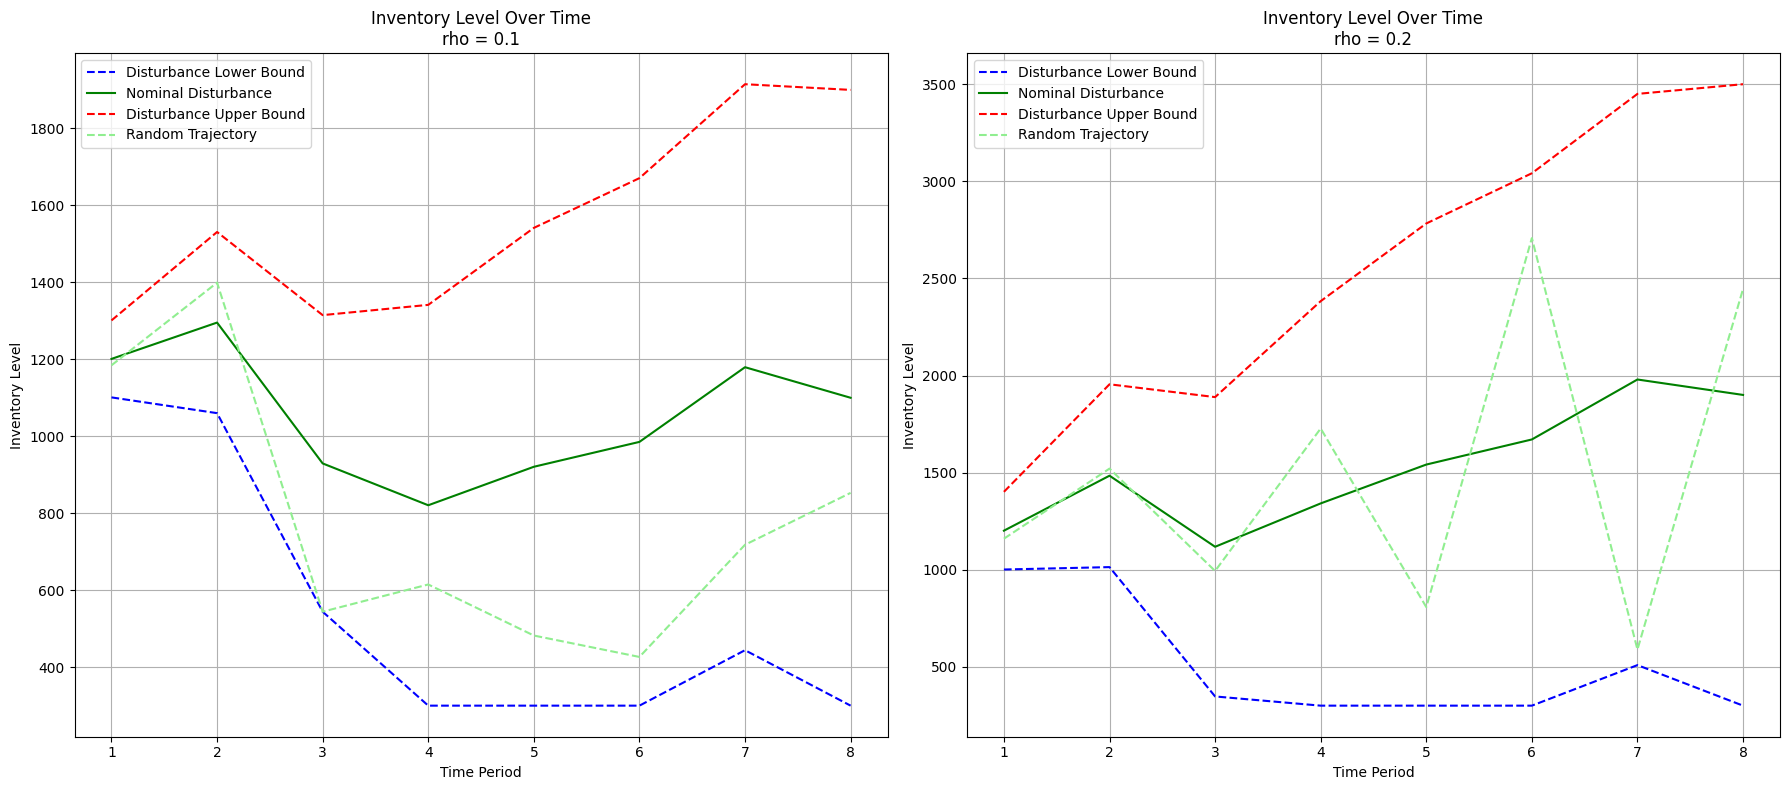

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8)) 
rho_values = [0.1, 0.2]

for i, rho in enumerate(rho_values):
    c, d, rhs_upper, rhs_lower, d_star = setup_parameters(rho)
    optimal_value, p_value = solve_problem(d)
        
    print(f"rho = {rho}: The robust optimal value is {optimal_value:.3E}")
        
    low_values, mid_values, high_values, random_traj = calculate_inventory_levels(p_value, rhs_upper, d_star, rhs_lower)
    plot_inventory_levels(axs[i], low_values, mid_values, high_values,random_traj, rho)
    
plt.tight_layout()
plt.show()

## References

1. Ben-Tal, Aharon, Alexander Goryashko, Elana Guslitzer, and Arkadi Nemirovski. 2004. Adjustable robust solutions of uncertain linear programs. Mathematical Programming 99(2) 351-376. - add a clickable link